In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.pipeline import make_pipeline
import pickle
# Import seaborn
import seaborn as sns
# Import train-test splitting library dari sklearn (scikit learn)
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
# untuk data imputation numerik
from sklearn.impute import SimpleImputer
# untuk standardisasi data
from sklearn.preprocessing import StandardScaler, OneHotEncoder
# Import dari sklearn
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestClassifier, BaggingRegressor, RandomForestRegressor,AdaBoostRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.datasets import make_classification
from sklearn.compose import make_column_transformer

# Machine Learning Project: Prediction of Used Phone Price

Untuk pihak penjual output bisa dijadikan acuan untuk menentukan harga barang. Untuk pembeli output bsia digunakan sebagai patokan untuk mencari barang dengan harga yang fair. 

Objective Metrics

| Objektif  | User Journey |
| :--: | :--: | 
| Untuk menentukan harga pasar handphone bekas | Dengan memasukan tipe hp, kapasitas dan kondisi bisa ditentukan harga pasar kebanyakan untuk handphone tersebut |

Data Preparation:
1. Data Gathering: Data gathering dilakukan dengan scraping data handphone bekas dari website carousell
2. Data Definition
3. Data Validation
4. Data Defense

In [2]:
def importData(filename):
    data = pd.read_csv(filename)
    duplicate_status = data.duplicated()
    duplicated_sum = duplicate_status.sum()
    print(f"Data setelah drop: {data.shape}")
    if duplicated_sum >0:
        data.drop_duplicates()
        print(f"Data setelah drop: {data.shape}")
    else:
        print(f"Data setelah drop: {data.shape}")
    return data

In [3]:
# input
file_phone = "phone_final_filtered.csv"

# panggil fungsi
data = importData(filename = file_phone)

Data setelah drop: (2295, 10)
Data setelah drop: (2295, 10)


1. Jenis Handphone   : Text, merek dan seri handphone
2. Harga             : Numerikal, harga handphone
3. Storage           : Numerikal, terdiri dari 32, 64, 128, 256, 512. Merupakan kapasitas memori dari hp
4. Ukuran Layar      : Numerikal, ukuran layar secara diagonal dalam inchi
5. Kamera Utama      : Numerikal, Megapixel dari kamera utama
6. Kapasitas Baterai : Numerikal, Kapasitas baterai dalam satuan mAh
7. Kamera Depan      : Numerikal, Megapixel dari kamera depan
8. Kondisi           : Kategorikal, terdiri dari brand new, like new, lightly used, well used, used, heavily used. 
9. Tipe              : Kategorikal, jenis handphone (android/apple)
10. Merek            : Text, merek/brand handphone (iphone, samsung,google,lg,etc)
brand new disini bukan berarti barang sama nilainya dengan beli dari toko resmi. Karena dalam satu contoh kasus barang sudah dibuka seminggu dan pada kasus lainnya dari tangan kedua tidak resmi

In [4]:
data.head(10)

,Jenis Handphone,Harga,Storage,Ukuran_Layar_(inchi),Kamera_Utama_(mp),Kapasitas_Baterai_(mah),Kamera_Depan_(mp),Kondisi,Tipe,Merek
0,google pixel 4a,7900000,128,5.81,12,3140,8,Like new,android,google
1,lg g7+,5750000,128,6.10,16,3000,8,Like new,android,lg
2,lg velvet,6900000,128,6.80,48,4300,16,Well used,android,lg
3,lg velvet,6000000,128,6.80,48,4300,16,Lightly used,android,lg
4,OPPO A12,2100000,32,6.22,13,4230,5,Like new,android,oppo
5,OPPO A15,875000,64,6.52,13,4230,5,Well used,android,oppo
6,OPPO A16,1150000,32,6.52,13,5000,8,Lightly used,android,oppo
7,OPPO A16,1000000,32,6.52,13,5000,8,Lightly used,android,oppo
8,OPPO A16,1600000,32,6.52,13,5000,8,Like new,android,oppo
9,OPPO A16,2200000,32,6.52,13,5000,8,Lightly used,android,oppo


In [5]:
# Tipe data di masing-masing kolom
data.dtypes

Jenis Handphone             object
Harga                        int64
Storage                      int64
Ukuran_Layar_(inchi)       float64
Kamera_Utama_(mp)            int64
Kapasitas_Baterai_(mah)      int64
Kamera_Depan_(mp)            int64
Kondisi                     object
Tipe                        object
Merek                       object
dtype: object

In [6]:
#Statistik untuk data numerikal
data.describe()

,Harga,Storage,Ukuran_Layar_(inchi),Kamera_Utama_(mp),Kapasitas_Baterai_(mah),Kamera_Depan_(mp)
count,2.295000e+03,2295.000000,2295.000000,2295.000000,2295.000000,2295.000000
mean,6.838892e+06,177.094553,6.107115,17.491068,3425.010458,10.993464
std,4.740854e+06,99.876546,0.422098,13.656031,773.089981,5.124556
min,4.750000e+05,32.000000,4.000000,5.000000,1715.000000,1.000000
25%,3.500000e+06,128.000000,6.000000,12.000000,2942.000000,7.000000
50%,5.800000e+06,128.000000,6.100000,12.000000,3110.000000,12.000000
75%,8.500000e+06,256.000000,6.400000,12.000000,4000.000000,12.000000
max,2.700000e+07,512.000000,7.600000,108.000000,6000.000000,48.000000


### 3.4. Cek Outliers

<AxesSubplot:xlabel='Harga'>

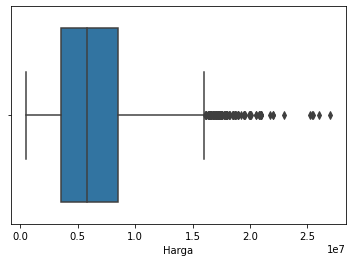

In [7]:
sns.boxplot(data = data, x = "Harga")

<AxesSubplot:>

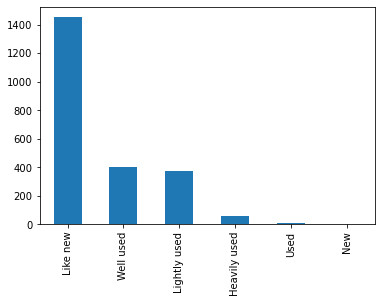

In [8]:
data['Kondisi'].value_counts().plot(kind='bar')
#reindex(['Like new','New','Used','Well used','Heavily used','Lightly used','Used'], fill_value=0)

<AxesSubplot:>

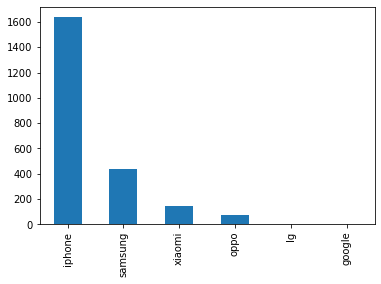

In [9]:
data['Merek'].value_counts().plot(kind='bar')
#reindex(['iphone','samsung','xiaomi','oppo','lg'], fill_value=0)

C:\Users\Adinda Gita\AppData\Local\Temp\ipykernel_9980\2198444681.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  data.hist(ax = ax,bins=5)


array([[<AxesSubplot:title={'center':'Harga'}>,
        <AxesSubplot:title={'center':'Storage'}>],
       [<AxesSubplot:title={'center':'Ukuran_Layar_(inchi)'}>,
        <AxesSubplot:title={'center':'Kamera_Utama_(mp)'}>],
       [<AxesSubplot:title={'center':'Kapasitas_Baterai_(mah)'}>,
        <AxesSubplot:title={'center':'Kamera_Depan_(mp)'}>]], dtype=object)

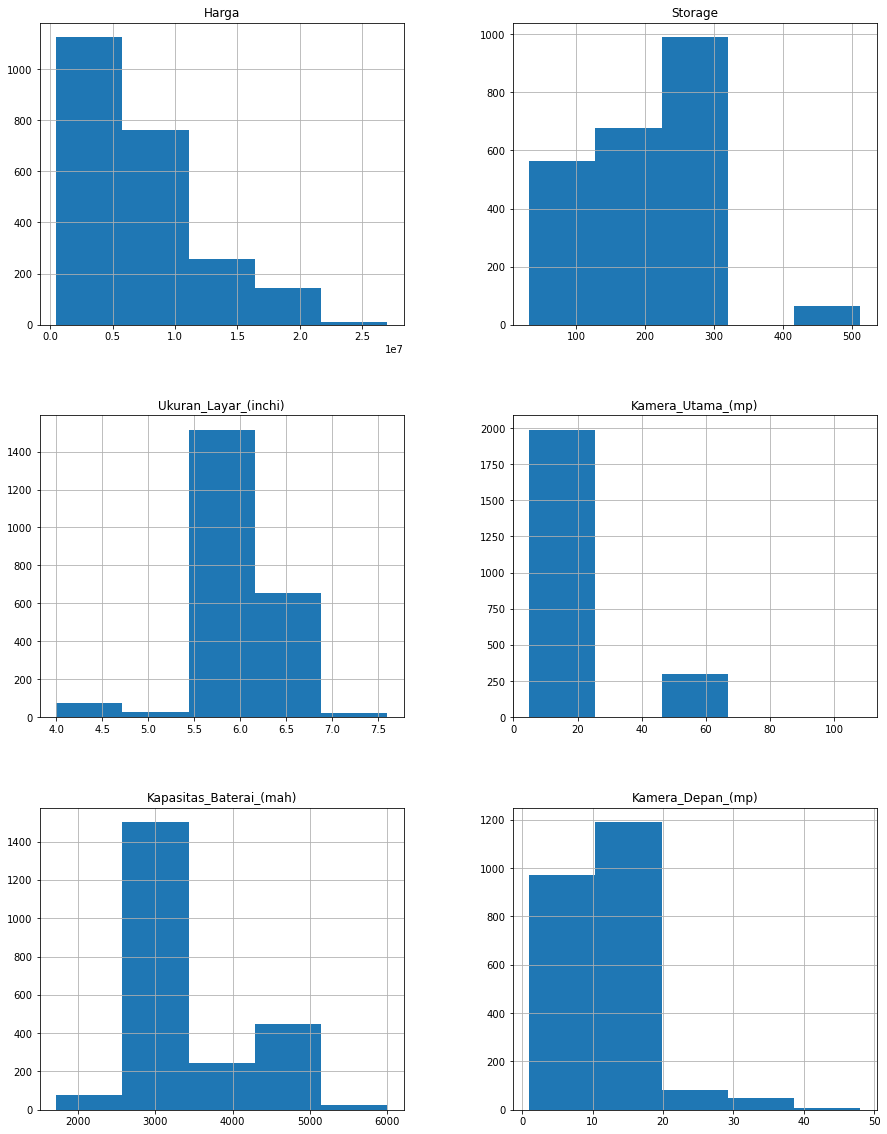

In [10]:
fig = plt.figure(figsize = (15,20))
ax = fig.gca()
data.hist(ax = ax,bins=5)

<AxesSubplot:>

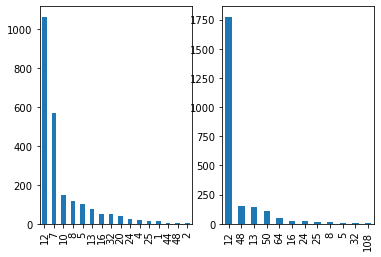

In [11]:
#kamera mau dibuat numerikal apa kategorikal??
fig, axes = plt.subplots(nrows=1, ncols=2)
data["Kamera_Depan_(mp)"].value_counts().plot(ax=axes[0], kind='bar')
data["Kamera_Utama_(mp)"].value_counts().plot(ax=axes[1], kind='bar')

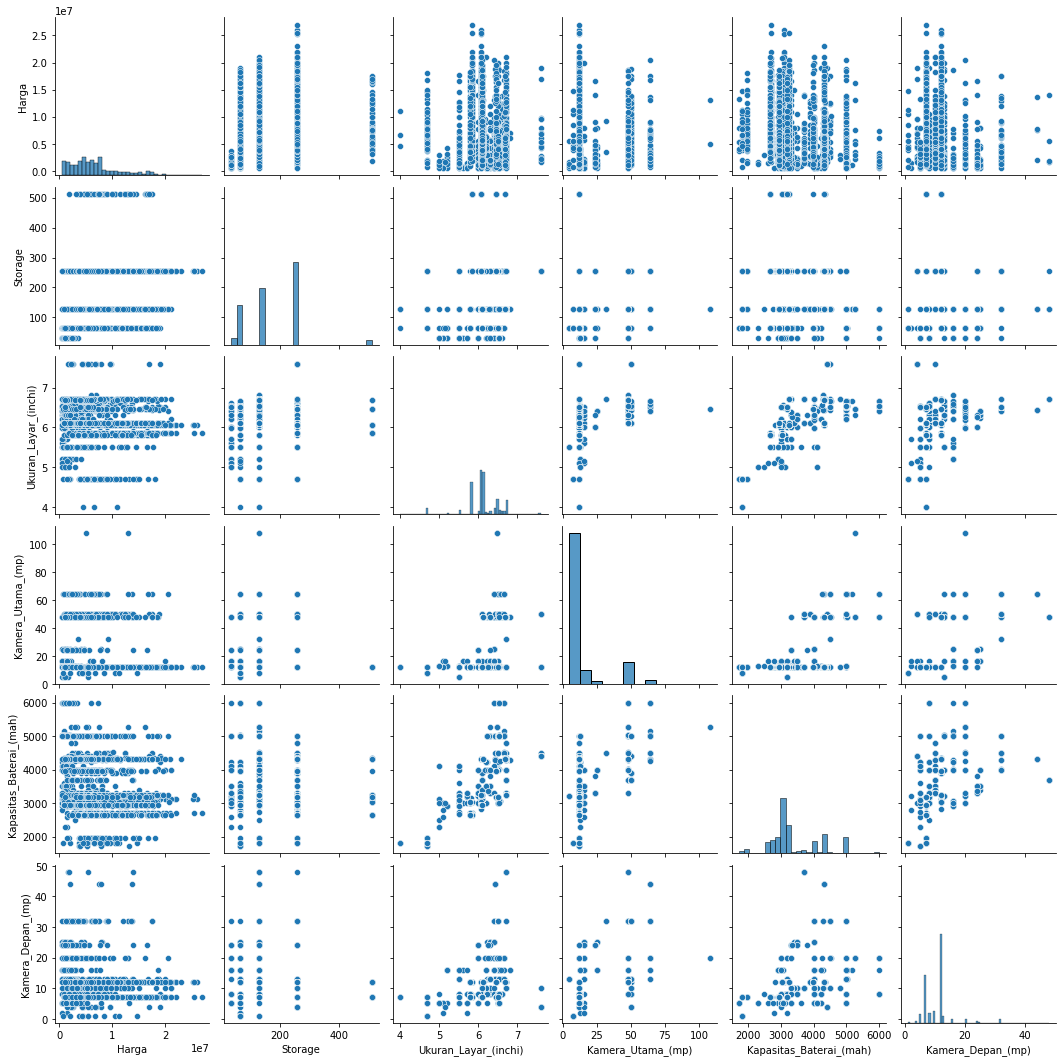

In [12]:
Lpairplot=sns.pairplot(data)

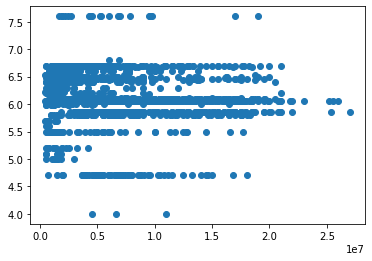

In [13]:
weightpriceplot=plt.scatter(data["Harga"], data["Ukuran_Layar_(inchi)"])

Text(0.5, 1.0, 'Correlation Heatmap')

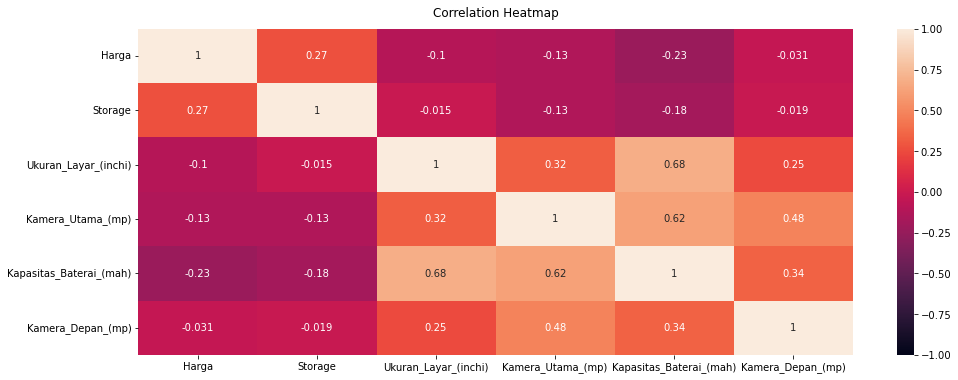

In [14]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(data.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12)

14 Juni 2023

1. Data kamera jadi numerikal, masukin ke histogram aja

In [15]:
# one_hot_encoded_data = pd.get_dummies(data, columns = ["Kondisi", "Tipe", "Merek"])
# one_hot_encoded_data
columns_to_fit = ["Kondisi", "Tipe", "Merek"]
enc = OneHotEncoder(handle_unknown='ignore',sparse=False).fit(data.loc[:, columns_to_fit])

In [16]:
column_names = enc.get_feature_names(columns_to_fit)
encoded_variables = pd.DataFrame(enc.transform(data.loc[:, columns_to_fit]), columns=column_names)
data = data.drop(columns_to_fit, 1)
one_hot_encoded_data = pd.concat([data, encoded_variables], axis=1)

C:\Users\Adinda Gita\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Adinda Gita\AppData\Local\Temp\ipykernel_9980\3517850960.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  data = data.drop(columns_to_fit, 1)


In [17]:
one_hot_encoded_data

,Jenis Handphone,Harga,Storage,Ukuran_Layar_(inchi),Kamera_Utama_(mp),Kapasitas_Baterai_(mah),Kamera_Depan_(mp),Kondisi_Heavily used,Kondisi_Lightly used,Kondisi_Like new,...,Kondisi_Used,Kondisi_Well used,Tipe_android,Tipe_iphone,Merek_google,Merek_iphone,Merek_lg,Merek_oppo,Merek_samsung,Merek_xiaomi
0,google pixel 4a,7900000,128,5.81,12,3140,8,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,lg g7+,5750000,128,6.10,16,3000,8,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,lg velvet,6900000,128,6.80,48,4300,16,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,lg velvet,6000000,128,6.80,48,4300,16,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,OPPO A12,2100000,32,6.22,13,4230,5,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2290,iphone xs max,6450000,64,6.50,12,3174,7,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
2291,iphone xs max,5800000,64,6.50,12,3174,7,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
2292,iphone xs max,4200000,64,6.50,12,3174,7,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
2293,iphone xs max,4000000,64,6.50,12,3174,7,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0


Text(0.5, 1.0, 'Correlation Heatmap')

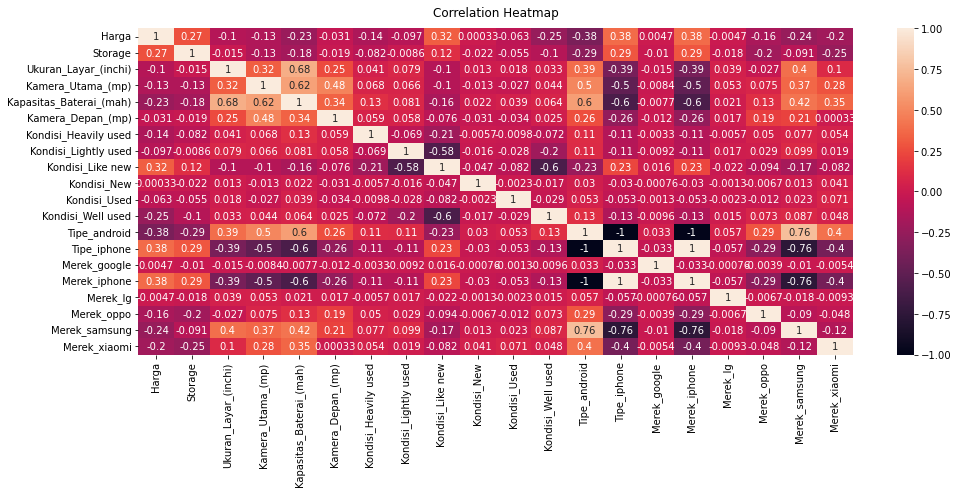

In [18]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(one_hot_encoded_data.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12)

In [19]:
def extractInputOutput(data,
                       output_column_name,
                       column_to_drop):

    # drop data
    data = data.drop(columns = column_to_drop,axis = 1)
    output_data = data[output_column_name]
    input_data = data.drop(output_column_name,
                           axis = 1)
    
    return input_data, output_data

In [20]:
# Jangan sampai salah urutan dalam penempatan return
output_column_name = ["Harga"]

X, y = extractInputOutput(data = one_hot_encoded_data,
                          output_column_name = output_column_name,
                         column_to_drop = "Jenis Handphone")

In [21]:
X.head(3)

,Storage,Ukuran_Layar_(inchi),Kamera_Utama_(mp),Kapasitas_Baterai_(mah),Kamera_Depan_(mp),Kondisi_Heavily used,Kondisi_Lightly used,Kondisi_Like new,Kondisi_New,Kondisi_Used,Kondisi_Well used,Tipe_android,Tipe_iphone,Merek_google,Merek_iphone,Merek_lg,Merek_oppo,Merek_samsung,Merek_xiaomi
0,128,5.81,12,3140,8,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,128,6.10,16,3000,8,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,128,6.80,48,4300,16,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [22]:
y.head(3)

,Harga
0,7900000
1,5750000
2,6900000


In [23]:
print(X.shape)
print(y.shape)

(2295, 19)
(2295, 1)


**Train Test Split Function**
1. `X` adalah input
2. `y` adalah output (target)
3. `test_size` adalah seberapa besar proporsi data test dari keseluruhan data. Contoh `test_size = 0.2` artinya data test akan berisi 20% data.
4. `random_state` adalah kunci untuk random. Harus di-setting sama. Misal `random_state = 123`.
5. Output:
   - `X_train` = input dari data training
   - `X_test` = input dari data testing
   - `y_train` = output dari data training
   - `y_test` = output dari data testing
6. Urutan outputnya: `X_train, X_test, y_train, y_test`. Tidak boleh terbalik

In [24]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.25,
                                                    random_state = 12)

In [25]:
# Sanity check hasil splitting
print(X_train.shape)
print(X_test.shape)

(1721, 19)
(574, 19)


In [26]:
# Ratio
X_test.shape[0] / X.shape[0]

0.25010893246187366

### **Data Imputation**

- Proses pengisian data yang kosong (NaN)
- Ada 2 hal yang diperhatikan:
  - Numerical Imputation
  - Categorical Imputation

**Cek data yang kosong dari variabel input**

In [27]:
X_train.isnull().sum()

Storage                    0
Ukuran_Layar_(inchi)       0
Kamera_Utama_(mp)          0
Kapasitas_Baterai_(mah)    0
Kamera_Depan_(mp)          0
Kondisi_Heavily used       0
Kondisi_Lightly used       0
Kondisi_Like new           0
Kondisi_New                0
Kondisi_Used               0
Kondisi_Well used          0
Tipe_android               0
Tipe_iphone                0
Merek_google               0
Merek_iphone               0
Merek_lg                   0
Merek_oppo                 0
Merek_samsung              0
Merek_xiaomi               0
dtype: int64

In [28]:
# Assuming your dataset is stored in a DataFrame called 'data'
numerical_columns = ['Storage', 'Ukuran_Layar_(inchi)', 'Kamera_Utama_(mp)', 'Kapasitas_Baterai_(mah)', 'Kamera_Depan_(mp)']

# Create a StandardScaler object
scaler = StandardScaler()

# Apply standardization to the numerical columns
X_train[numerical_columns] = scaler.fit_transform(X_train[numerical_columns])

In [29]:
X_train.head()

,Storage,Ukuran_Layar_(inchi),Kamera_Utama_(mp),Kapasitas_Baterai_(mah),Kamera_Depan_(mp),Kondisi_Heavily used,Kondisi_Lightly used,Kondisi_Like new,Kondisi_New,Kondisi_Used,Kondisi_Well used,Tipe_android,Tipe_iphone,Merek_google,Merek_iphone,Merek_lg,Merek_oppo,Merek_samsung,Merek_xiaomi
1340,3.410343,-0.129134,-0.398875,-0.243873,0.204405,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
13,-1.142954,0.255281,-0.325504,2.067432,-0.590580,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
909,0.808459,-0.129134,-0.398875,-0.414594,0.204405,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
2096,-0.492483,-0.033030,-0.398875,-0.635219,-0.789326,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
37,-0.492483,-2.195365,-0.325504,-0.690375,0.999389,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


## <b><font color='blue'> 3. Training Machine Learning:</font></b>
---
    * Choose Score to optimize and Hyperparameter Space
    * Cross-Validation: Random vs Grid Search CV
    * Kita harus mengalahkan benchmark

### **Benchmark / Baseline**

- Baseline untuk evaluasi nanti
- Karena ini klasifikasi, bisa kita ambil dari proporsi kelas target yang terbesar
- Dengan kata lain, menebak hasil output marketing response dengan nilai "no" semua tanpa modeling

In [30]:
y_train.value_counts()

# baseline akurasi = 78%

Harga   
7400000     46
5500000     45
7500000     38
4700000     36
4000000     33
            ..
10999999     1
11100000     1
11150000     1
2620000      1
27000000     1
Length: 355, dtype: int64

### **1. Import Model**

- Misal gunakan 3 model ML untuk penentuan harga:
1. K Nearest Neighbor
2. Logistic Regression
3. Lasso Regression
4. Ridge Regression
5. Random Forest Regressor
6. Decision Tree Regressor
7. Gradient Boosting Regressor

### **2. Fitting Model**

- Cara fitting/training model mengikuti yang dokumentasi model

In [31]:
# Model K nearest neighbor
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

C:\Users\Adinda Gita\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


KNeighborsClassifier()

In [32]:
# Linear Regression
linear_reg = LinearRegression()
linear_reg.fit(X_train, y_train)

LinearRegression()

In [33]:
lasso_reg = Lasso(alpha=1)  # Example alpha value
lasso_reg.fit(X_train, y_train)

C:\Users\Adinda Gita\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.128e+13, tolerance: 3.956e+12
  model = cd_fast.enet_coordinate_descent(


Lasso(alpha=1)

In [34]:
ridge_reg = Ridge(alpha=1)  # Example alpha value
ridge_reg.fit(X_train, y_train)

Ridge(alpha=1)

In [35]:
# Model Random Forest regressor
random_forest = RandomForestRegressor(random_state = 123)
random_forest.fit(X_train, y_train)

C:\Users\Adinda Gita\AppData\Local\Temp\ipykernel_9980\3080224846.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  random_forest.fit(X_train, y_train)


RandomForestRegressor(random_state=123)

In [36]:
tree = DecisionTreeRegressor(random_state = 123)
tree.fit(X_train, y_train)

DecisionTreeRegressor(random_state=123)

In [37]:
gb_reg = GradientBoostingRegressor(random_state=123)
gb_reg.fit(X_train, y_train)

C:\Users\Adinda Gita\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GradientBoostingRegressor(random_state=123)

### **3. Prediction**

- Saatnya melakukan prediksi

In [38]:
predicted_knn = pd.DataFrame(knn.predict(X_train))
predicted_knn.head()

,0
0,4000000
1,500000
2,4700000
3,4500000
4,500000


In [39]:
predicted_linear = pd.DataFrame(linear_reg.predict(X_train))
predicted_linear

,0
0,1.071351e+07
1,-1.291774e+05
2,7.619726e+06
3,8.267490e+06
4,3.053400e+06
...,...
1716,5.062393e+06
1717,7.833110e+06
1718,6.287011e+06
1719,9.398134e+06


In [40]:
predicted_lasso = pd.DataFrame(lasso_reg.predict(X_train))
predicted_lasso

,0
0,1.071351e+07
1,-1.291071e+05
2,7.619721e+06
3,8.267491e+06
4,3.053425e+06
...,...
1716,5.062400e+06
1717,7.833108e+06
1718,6.287017e+06
1719,9.398134e+06


In [41]:
predicted_ridge = pd.DataFrame(ridge_reg.predict(X_train))
predicted_ridge

,0
0,1.071477e+07
1,-7.540812e+04
2,7.617709e+06
3,8.267131e+06
4,3.068918e+06
...,...
1716,5.064135e+06
1717,7.825375e+06
1718,6.288031e+06
1719,9.389363e+06


In [42]:
predicted_rf = pd.DataFrame(random_forest.predict(X_train))
predicted_rf.head()

,0
0,7.459213e+06
1,9.825500e+05
2,7.069201e+06
3,8.221897e+06
4,5.216729e+06


In [43]:
predicted_gb = pd.DataFrame(gb_reg.predict(X_train))
predicted_gb.head()

,0
0,9.345965e+06
1,2.667482e+05
2,7.596093e+06
3,8.432921e+06
4,5.900883e+06


### **4. Cek performa model di data training**

In [44]:
# akurasi knn
knn_score = knn.score(X_train, y_train)
# akurasi logistic regression
linear_reg_score = linear_reg.score(X_train, y_train)
# akurasi lasso regression
lasso_reg_score = lasso_reg.score(X_train, y_train)
# akurasi ridge regression
ridge_reg_score = ridge_reg.score(X_train, y_train)
# akurasi random forest
random_forest_score = random_forest.score(X_train, y_train)
# akurasi decision tree regressor
tree_score = tree.score(X_train, y_train)
# akurasi gradient boosting regresssor
gb_reg_score = gb_reg.score(X_train, y_train)

In [45]:
model_score = {
    "Model": ["KNN", "Linear Regression", "Lasso Regression", "Ridge Regression", "Random Forest Regressor", "Decision Tree Regressor", "Gradient Boosting Regressor"],
    "Score": [knn_score, linear_reg_score,lasso_reg_score,ridge_reg_score,random_forest_score,tree_score,gb_reg_score]
}


In [46]:
score = pd.DataFrame(model_score)
score

,Model,Score
0,KNN,0.134805
1,Linear Regression,0.241912
2,Lasso Regression,0.241912
3,Ridge Regression,0.241802
4,Random Forest Regressor,0.382152
5,Decision Tree Regressor,0.392852
6,Gradient Boosting Regressor,0.316866


---
## Decision Tree Optimation

- Resampling n data 
- Sample yang sudah terpilih dapat diambil kembali (with replacement)

In [59]:
params = {"max_depth": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]}

# Buat gridsearch
tree = DecisionTreeRegressor(random_state = 123)

tree_cv = GridSearchCV(estimator = tree,
                       param_grid = params,
                       cv = 5,
                       scoring = "neg_mean_squared_error")

In [60]:
# Fit grid search cv
tree_cv.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(random_state=123),
             param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                       13, 14, 15, 16, 17, 18, 19, 20]},
             scoring='neg_mean_squared_error')

In [61]:
# Best params
tree_cv.best_params_

{'max_depth': 2}

In [75]:
# Refit the bagging tree
tree = DecisionTreeRegressor(random_state = 123)

tree.fit(X_train, y_train)

DecisionTreeRegressor(random_state=123)

In [76]:
tree.score(X_train, y_train)

0.39285228681067264

In [85]:
# Refit the bagging tree
tree_best = DecisionTreeRegressor(max_depth = tree_cv.best_params_["max_depth"],
                             random_state = 123)

tree_best.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=2, random_state=123)

In [86]:
tree_best.score(X_train, y_train)

0.2548203049981107

In [87]:
# Predict
y_pred_train = tree.predict(X_train)

# RMSE
rmse_train_dt = mean_squared_error(y_train, y_pred_train,squared=False)
rmse_cv_dt = -tree_cv.best_score_

print(f"RMSE Train :{rmse_train_dt:}")
print(f"RMSE CV    :{rmse_cv_dt:}")

RMSE Train :4138723.341063269
RMSE CV    :17181664734617.621


In [88]:
# Predict
y_pred_train_best = tree_best.predict(X_train)

# RMSE
rmse_train_best_dt = mean_squared_error(y_train, y_pred_train_best,squared=False)
rmse_cv_best_dt = -tree_cv.best_score_

print(f"RMSE Train :{rmse_train_dt:}")
print(f"RMSE CV    :{rmse_cv_dt:}")

RMSE Train :4138723.341063269
RMSE CV    :17181664734617.621


In [80]:
n_scores = cross_val_score(tree, X_train, y_train,
                           cv=KFold(n_splits=5, shuffle=True, random_state=1))

---
# Preparing Test Data

In [81]:
# Apply standardization to the numerical columns
X_test[numerical_columns] = scaler.fit_transform(X_test[numerical_columns])

In [82]:
X_test.head(10)

,Storage,Ukuran_Layar_(inchi),Kamera_Utama_(mp),Kapasitas_Baterai_(mah),Kamera_Depan_(mp),Kondisi_Heavily used,Kondisi_Lightly used,Kondisi_Like new,Kondisi_New,Kondisi_Used,Kondisi_Well used,Tipe_android,Tipe_iphone,Merek_google,Merek_iphone,Merek_lg,Merek_oppo,Merek_samsung,Merek_xiaomi
2087,-1.104818,0.029135,-0.41209,-0.596495,-0.753238,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
2196,0.739580,-0.541244,-0.41209,-0.948737,-0.753238,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
2216,0.739580,-0.541244,-0.41209,-0.948737,-0.753238,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
1770,-0.490019,-3.164990,-0.41209,-1.814456,-0.753238,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
744,3.198778,-0.062126,-0.41209,-0.388127,0.174570,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
643,-1.412218,0.987373,-0.41209,-0.425336,-1.124362,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2037,-0.490019,0.029135,-0.41209,-0.596495,-0.753238,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
1871,0.739580,-0.541244,-0.41209,-0.876800,-0.753238,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
1038,-1.104818,0.029135,-0.41209,-0.388127,0.174570,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
2056,-0.490019,0.029135,-0.41209,-0.596495,-0.753238,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0


In [70]:
# Refit the bagging tree
tree = DecisionTreeRegressor(random_state = 123)

tree.fit(X_test, y_test)

DecisionTreeRegressor(random_state=123)

In [71]:
tree.score(X_test, y_test)

0.4613394172953593

In [72]:
print(n_scores)
print(n_scores.mean())

[0.06869777 0.0984092  0.07038689 0.12016938 0.1368513 ]
0.09890290907955082


In [89]:
# Refit the bagging tree
tree_best = DecisionTreeRegressor(max_depth = tree_cv.best_params_["max_depth"],
                                  random_state = 123)

tree_best.fit(X_test, y_test)

DecisionTreeRegressor(max_depth=2, random_state=123)

In [90]:
tree_best.score(X_test, y_test)

0.2665822623007045

In [91]:
print(n_scores)
print(n_scores.mean())

[0.21701488 0.27074967 0.23506883 0.31411625 0.21878239]
0.2511464033815634


Skor yang didapatkan dengan max depth tree lebih stabil dibandingkan tanpa menentukan parameter max depth